---
# Extra Credit

In this extra credit assignment, we will further explore the concept of floating point 
representations. In particular, you will

1. Design appropriate floating point representations considering various functional 
(precision, range, etc.) and non-functional (performance, memory footprint, 
compatibility, etc.) requirements
1. Evaluate floating point representations according to various functional and 
non-functional requirements

in the context of machine learning systems. **Note that you do NOT need to know any 
machine learning to successfully complete this assignment.**

The extra credit is worth a total of 100 points. If you have any questions or need 
assistance, please don't hesitate to reach out to us during office hours or post your 
questions on the `Ed Discussion` forum.

---
# Assignment

---
## Part 1: Design (50 points)

In this section, you will propose a new floating point format to accelerate machine 
learning systems.

Training and running modern machine learning models, such as ChatGPT, requires 
performing billions, trillions, quadrillions or even quintillions of floating point 
operations. By analyzing the unique workload imposed by machine learning, it's possible 
to design more efficient floating point representations than the IEEE standard 32-bit 
(`float`) and 64-bit (`double`) representations.

The code below trains a neural network (a type of machine learning model) to classify
images of handwritten digits. That is, given an image of a handwritten digit (0-9) the
neural network outputs the digit.

![An image containing handwritten digits of the numbers from 0 to 9.](MNIST.png)

For example, the image in the upper left contains the digit `0`. Assuming the neural
network is trained correctly, it should also output `0`.

---
### Neural Network Code

First, import some libraries.

In [37]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from scipy import stats

Next, define the neural network. It's OK if you don't understand how this code works,
it's not important.

In [38]:
class NeuralNetwork:
    def __init__(self, layers, callback=None):
        self.layers = layers

        self.callback = callback
        if self.callback is None:
            self.callback = lambda x: x

    def forward(self, x):
        self.callback(x)
        z = x
        for layer in self.layers:
            z = layer.forward(z)
        return z

    def backward(self, dz):
        dx = dz
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        return dx

    def get_parameters(self):
        return [
            parameter 
            for layer in self.layers 
            for parameter in layer.get_parameters()
        ]

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
        

class Linear:
    def __init__(self, in_features, out_features, callback=None):
        self.in_features = in_features
        self.out_features = out_features

        self.W = np.zeros((out_features, in_features))
        self.b = np.zeros(out_features)
        self.dW = np.zeros((out_features, in_features))
        self.db = np.zeros(out_features)

        self.x = np.empty(0)

        self.callback = callback
        if self.callback is None:
            self.callback = lambda x: x

        self.reset_parameters()

    def forward(self, x):
        self.x = x.copy()
        z = self.callback(self.callback(self.W @ x) + self.b)
        return z

    def backward(self, dz):
        self.dW += self.callback(np.outer(dz, self.x))
        self.callback(self.dW)
        self.db += dz
        self.callback(self.db)
        dx = self.callback(self.W.T @ dz)
        return dx

    def get_parameters(self):
        return [(self.W, self.dW), (self.b, self.db)]

    def reset_parameters(self):
        r = 4.0 * (6.0 / (self.in_features + self.out_features))
        self.W = np.random.uniform(-r, r, size=self.W.shape)
        self.callback(self.W)
        self.b = np.random.uniform(0, 1, size=self.b.shape)
        self.callback(self.b)


class Sigmoid:
    def __init__(self, callback=None):
        self.z = np.empty(0)

        self.callback = callback
        if self.callback is None:
            self.callback = lambda x: x

    def forward(self, x):
        x_neg = self.callback(-x)
        x_exp = self.callback(np.exp(x_neg))
        x_exp_shf = self.callback(1.0 + x_exp)
        z = self.callback(1.0 / x_exp_shf)
        self.z = z.copy()
        return z

    def backward(self, dz):
        dx = self.callback(dz * self.callback(self.z * self.callback(1 - self.z)))
        return dx

    def get_parameters(self):
        return []

    def reset_parameters(self):
        return


class CrossEntropyCriterion:
    def __init__(self, callback=None):
        self.x = np.empty(0)
        self.y = np.empty(0)

        self.callback = callback
        if self.callback is None:
            self.callback = lambda x: x

    def forward(self, x, y):
        self.x = x.copy()
        self.y = y.copy()
        x_max = np.max(x)
        x_norm = self.callback(x - x_max)
        x_exp = self.callback(np.exp(x_norm))
        x_sum = self.callback(np.sum(x_exp))
        x_log = self.callback(np.log(x_sum))
        y_hat = self.callback(x_norm - x_log)
        return -y_hat[y.argmax()]

    def backward(self):
        dx = self.callback(self.x - self.y)
        return dx


class StochasticGradientDescentOptimizer:
    def __init__(self, learning_rate, batch_size, callback=None):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.step_count = 0

        self.callback = callback
        if self.callback is None:
            self.callback = lambda x: x

    def step(self, parameters):
        self.step_count += 1
        if self.step_count < self.batch_size:
            return
        self.step_count = 0

        scaled_learning_rate = (1 / self.batch_size) * self.learning_rate
        for p, dp in parameters:
            p -= self.callback(scaled_learning_rate * dp)
            self.callback(p)
            dp[...] = 0
            self.callback(dp)


class LogCallback:
    def __init__(self, p=0.5):
        self.p = p
        self.data = []

    def __call__(self, x):
        mask = np.random.random(size=x.shape) < self.p
        self.data.extend(x[mask].ravel())
        return x

Now, define the main function that will train the neural network. Again, it's OK if
you don't understand how this code works.

In [39]:
def main(epochs, callback, fast=False):
    model = NeuralNetwork(
        [
            Linear(784, 128, callback),
            Sigmoid(callback),
            Linear(128, 10, callback),
        ],
        callback
    )
    optimizer = StochasticGradientDescentOptimizer(0.01, 32, callback)
    criterion = CrossEntropyCriterion(callback)

    X, Y = fetch_openml("mnist_784", version=1, parser="auto", return_X_y=True)
    X, Y = X.to_numpy() / 255.0, Y.to_numpy()
    if fast:
        X, Y = X[:128], Y[:128]
    Y = np.array([[0 if int(y) != i else 1 for i in range(10)] for y in Y])

    idx = np.arange(len(X))
    for epoch in range(epochs):
        np.random.shuffle(idx)
        X, Y = X[idx], Y[idx]

        loss = 0.0
        correct = 0
        for x, y in zip(X, Y):
            y_hat = model.forward(x)
            correct += y_hat.argmax() == y.argmax()
            loss += criterion.forward(y_hat, y)
            model.backward(criterion.backward())
            optimizer.step(model.get_parameters())
        acc = correct / len(X)
        print(f"[Epoch {epoch + 1}/{epochs}] Accuracy is {100 * acc:.2f}%")

Train the neural network to classify the images of digits (without logging). Epochs are
a measurement of how long the neural network trains. Notice that the accuracy of the
network increases with the number of epochs.

In [40]:
main(epochs=5, callback=None)

[Epoch 1/5] Accuracy is 75.62%
[Epoch 2/5] Accuracy is 83.89%
[Epoch 3/5] Accuracy is 84.86%
[Epoch 4/5] Accuracy is 85.14%
[Epoch 5/5] Accuracy is 85.39%


Now, train the neural network with logging. The `LogCallback` records floating point
values observed during neural network training with probability `p`. These values are
then displayed in a histogram. The raw data can be accessed via `callback.data` for 
additional analysis. Since logging introduces some overhead, we pass the `fast=True` 
flag to only train the neural network on a small part of the data. This keeps training
relatively quick.

In [41]:
def plot_logger(logger):
    lower_percentile = np.percentile(logger.data, 5)
    upper_percentile = np.percentile(logger.data, 95)
    clipped_data = np.clip(logger.data, lower_percentile, upper_percentile)

    plt.xlabel("Observed Float Values")
    plt.ylabel("Frequency")
    plt.hist(clipped_data, bins=20)
    plt.show()

    print("Mean:", np.mean(logger.data))
    print("Median:", np.median(logger.data))
    print("Standard Deviation:", np.std(logger.data))
    print("Min:", np.min(logger.data))
    print("Max:", np.max(logger.data))

[Epoch 1/10] Accuracy is 7.81%
[Epoch 2/10] Accuracy is 17.97%
[Epoch 3/10] Accuracy is 17.19%
[Epoch 4/10] Accuracy is 21.09%
[Epoch 5/10] Accuracy is 28.12%
[Epoch 6/10] Accuracy is 25.78%
[Epoch 7/10] Accuracy is 28.91%
[Epoch 8/10] Accuracy is 38.28%
[Epoch 9/10] Accuracy is 32.03%
[Epoch 10/10] Accuracy is 39.84%


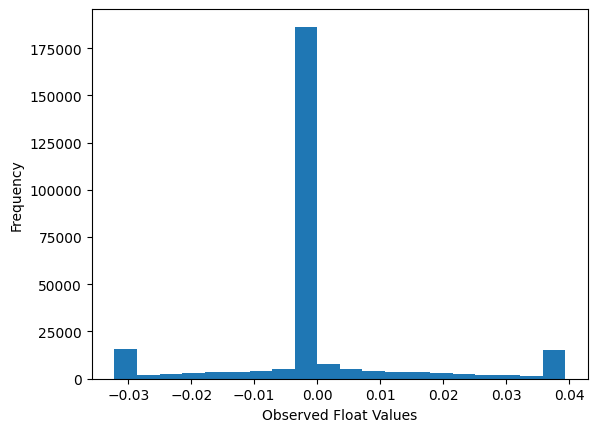

Mean: 0.004175751852115345
Median: 0.0
Standard Deviation: 0.13296107953413444
Min: -5.3360563692705245
Max: 18.47401114620625


In [42]:
logger = LogCallback(p=0.001)
main(epochs=10, callback=logger, fast=True)
plot_logger(logger)

---
### Design Your Floating Point Representation (50 points)

After observing the distribution of floating point values encountered during neural 
network training, propose a new floating point representation to accelerate training.

In particular, provide substantive explanation of and justification for for each 
component of your proposed floating point representation, including but not limited to

1. Total number of bits.
1. Number of exponent bits.
1. Number of fractional bits.
1. Value of the bias.
1. Denormalized values (included/not included and which values are denormalized).
1. Other special values.
1. Any other modifications of the IEEE standard representation.

Use multiple kinds of evidence to support your design decisions such as

1. Plots of the distribution of floating point values during training.
1. Summary statistics of the distribution of floating point values during training.
1. Performance measurements of larger (e.g. 64-bit) and smaller (e.g. 32-bit) floating
point representations.
1. Theoretical justification. For example, the distribution of floating point values
representable by your proposed format.

Consider multiple functional and non-functional factors in your design such as

1. Precision.
1. Range.
1. Performance.
1. Memory footprint.
1. Compatibility.
1. Implementation difficulty.
1. Training stability (will the network still train?).

<span style="color:red">TODO: Explain your design here.</span>

---
## Part 2: Implementation and Evaluation (50 points)

In this section, you will implement and evaluate a simulation of your proposed floating 
point format.

To implement the floating point format, you will use the `callback` argument provided by
the neural network training function `main`. During training, the `callback` function
will be called on every intermediate calculation in the neural network. This allows,
for example, logging the distribution of floating point values during training with
`LogCallback`. Here, you will use the `callback` argument to convert the actual IEEE 
64-bit floating point values to the values representable by your format.

For example, consider a 5-bit floating point format with one sign bit, two exponent 
bits, two fractional bits, zero bias and no special values. The following code 
implements this floating point format as a callback (`ConvertCallback`). The 
`ComposeCallback` is used to chain together multiple callbacks. For example, logging
with conversions.

In [43]:
from bisect import bisect_left


class ConvertCallback:
    def __init__(self):
        # All representable values.
        self.values = [
            -14.0, -12.0, -10.0, -8.0,
            -7.0, -6.0, -5.0, -4.0,
            -3.5, -3.0, -2.5, -2.0,
            -1.75, -1.5, -1.25, -1.0,
            1.0, 1.25, 1.5, 1.75,
            2.0, 2.5, 3.0, 3.5,
            4.0, 5.0, 6.0, 7.0,
            8.0, 10.0, 12.0, 14.0,
        ]

    def convert(self, value):
        # Find the index of the first representable float >= value.
        i = bisect_left(self.values, value)
        # If it is out of bounds, round to the maximum float.
        # Note that this is different than the IEEE standard rounding.
        if i == len(self.values):
            i -= 1
        # Return the representable float.
        return self.values[i]

    def __call__(self, x):
        # Create a copy of `x` to return.
        x = x.copy()

        # View `x` as a flat array.
        flat_x = x.ravel()

        # Convert each element in `x` into a representable float.
        for i in range(len(flat_x)):
            flat_x[i] = self.convert(flat_x[i])
        
        # Return the array.
        return x


class ComposeCallback:
    def __init__(self, callbacks):
        self.callbacks = callbacks
    
    def __call__(self, x):
        for callback in self.callbacks:
            x = callback(x)
        return x

Now, train the neural network using the simulated 5-bit floating point format. Use the
`fast=True` flag because of the conversion and logging overhead. 

Note that the neural network stops improving at ~14% accuracy unlike before where it 
reached ~40% accuracy without any signs of slowing down. In the histogram of the 
floating point values, we see that almost all floats encountered during training are 
either 1 or 14, while they were clustered around 0 with the IEEE format. Consider what 
might be happening here.

[Epoch 1/10] Accuracy is 14.06%
[Epoch 2/10] Accuracy is 14.06%
[Epoch 3/10] Accuracy is 14.06%
[Epoch 4/10] Accuracy is 14.06%
[Epoch 5/10] Accuracy is 14.06%
[Epoch 6/10] Accuracy is 14.06%
[Epoch 7/10] Accuracy is 14.06%
[Epoch 8/10] Accuracy is 14.06%
[Epoch 9/10] Accuracy is 14.06%
[Epoch 10/10] Accuracy is 14.06%


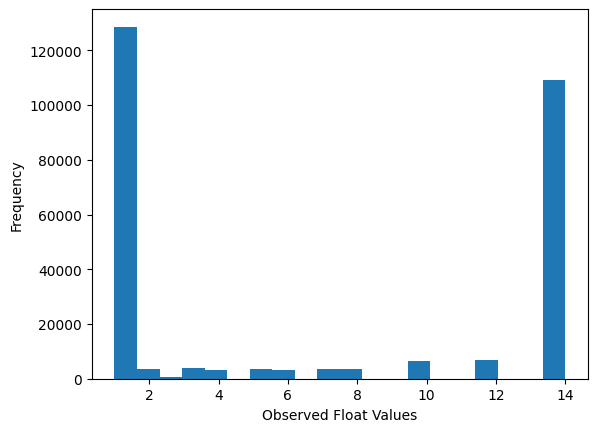

Mean: 6.541728788657369
Median: 4.0
Standard Deviation: 6.992589452298105
Min: -14.0
Max: 14.0


In [44]:
logger = LogCallback(p=0.001)
callback = ComposeCallback([ConvertCallback(), logger])
main(epochs=10, callback=callback, fast=True)
plot_logger(logger)

---
### Implement Your Floating Point Representation (25 points)

Implement your proposed floating point representation as a callback like 
`ConvertCallback`. Depending on your representation, you might need to use a different
implementation strategy than `ConvertCallback`. For example, there might be too many 
values to hardcode an array containing them. 

Try training the neural network with your callback.

In [45]:
# TODO: Write your implementation here.

---
### Evaluate Your Floating Point Representation (25 points)

After training a neural network with your proposed floating point format, evaluate your
design. Explain what worked well, what didn't and why. Propose at least one modification
to improve your design.

In particular, consider multiple functional and non-functional factors in your 
evaluation such as

1. Precision.
1. Range.
1. Performance.
1. Memory footprint.
1. Compatibility.
1. Implementation difficulty.
1. Training stability (will the network still train?).

Use multiple kinds of evidence to support your evaluation such as

1. Plots of the distribution of floating point values during training.
1. Summary statistics of the distribution of floating point values during training.

Justify your observations with connections to component(s) of your proposed floating 
point representation such as

1. Total number of bits.
1. Number of exponent bits.
1. Number of fractional bits.
1. Value of the bias.
1. Denormalized values (included/not included and which values are denormalized).
1. Other special values.
1. Any other modifications of the IEEE standard representation.

<span style="color:red">TODO: Evaluate your design here.</span>